In [268]:
import tensorflow as tf
import os

In [269]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)


In [270]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [271]:
import cv2
import imghdr

In [272]:
data_dir = 'data' 


In [273]:
image_exts = ['jpeg','jpg','bmp', 'png']

In [274]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [275]:
import numpy as np
from matplotlib import pyplot as plt

In [276]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 185 files belonging to 2 classes.


In [277]:
data_iterator = data.as_numpy_iterator()

In [278]:
data_iterator

In [279]:
batch= data_iterator.next()

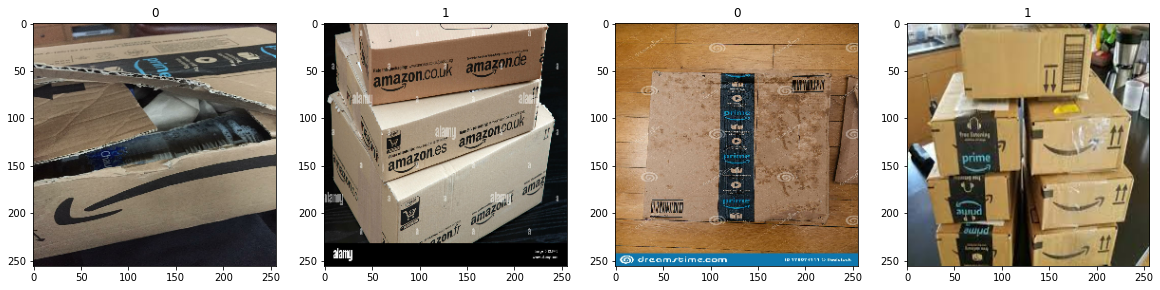

In [280]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [281]:
data = data.map(lambda x,y: (x/255, y))

In [282]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [283]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [284]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [285]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [286]:
model = Sequential()

In [287]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [288]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [289]:
logdir='logs'

In [290]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [291]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 3s 404ms/step - loss: 0.8024 - accuracy: 0.4844 - val_loss: 0.6653 - val_accuracy: 0.5312
Epoch 2/20
4/4 [==============================] - 2s 361ms/step - loss: 0.6643 - accuracy: 0.5391 - val_loss: 0.6394 - val_accuracy: 0.8438
Epoch 3/20
4/4 [==============================] - 2s 363ms/step - loss: 0.6214 - accuracy: 0.7188 - val_loss: 0.5977 - val_accuracy: 0.7188
Epoch 4/20
4/4 [==============================] - 2s 381ms/step - loss: 0.5565 - accuracy: 0.7812 - val_loss: 0.4244 - val_accuracy: 0.9688
Epoch 5/20
4/4 [==============================] - 2s 474ms/step - loss: 0.4467 - accuracy: 0.8438 - val_loss: 0.6685 - val_accuracy: 0.5938
Epoch 6/20
4/4 [==============================] - 2s 447ms/step - loss: 0.4509 - accuracy: 0.7656 - val_loss: 0.5115 - val_accuracy: 0.6875
Epoch 7/20
4/4 [==============================] - 2s 432ms/step - loss: 0.4092 - accuracy: 0.7812 - val_loss: 0.3439 - val_accuracy: 0.8750
Epoch 8/20
4/4 [====

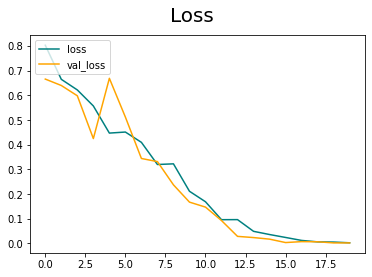

In [292]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

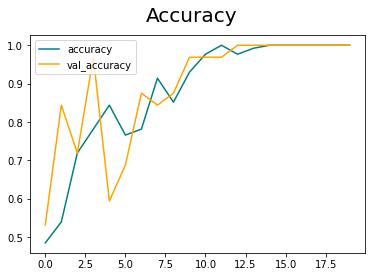

In [293]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [294]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [295]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [296]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 95ms/step


In [297]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [298]:
import cv2

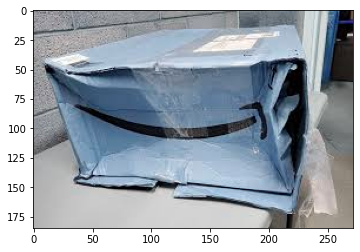

In [378]:
img = cv2.imread('images.jpg')
plt.imshow(img)
plt.show()

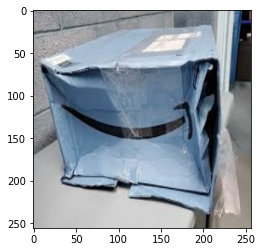

In [379]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [380]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 127ms/step


In [381]:
yhat

array([[0.00243085]], dtype=float32)

In [382]:
if yhat > 0.1: 
    print(f'Predicted class is Intact')
else:
    print(f'Predicted class is Damaged')

Predicted class is Damaged
